For this entry, I will be using the following python packages in this jupyter notebook:

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

## The Problem

You own a Halal food truck in NYC and want to know how much food you should have in stock for the afternoon rush. So between the hours of 11am to 3pm, you count how many patrons you get per hour. So at the end of a six months you have 720 counts of orders between 11am and 3pm. Here is the histogram you get from this data:

### Here is a test of h3

Hello there

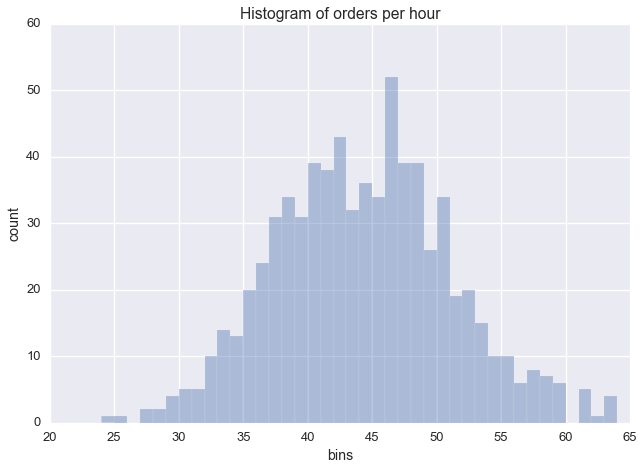

In [2]:
from scipy.stats import poisson, randint

# generates counts with noise
np.random.seed(42) 
mu = 42
counts = poisson.rvs(mu, size=720) + randint.rvs(-3, 3)

ax = sns.distplot(counts, kde=False, bins=40)
ax.set_xlabel("bins")
ax.set_ylabel("count")
ax.set_title("Histogram of orders per hour");

## Modeling

Looking at the histogram, the data seem skewed to the right and since we are dealing with count data, we can try to model the count data with a Possion distribution. The Possion distrubution is a fairly simple distribution with one parameter:

$$
p(x \ | \ \mu) = \frac{e^{-\mu}\mu^{x}} {x!} \mbox{    for    }  x = 0, 1, 2, \cdots
$$

where $\mu$ is both the mean and the variance. For this problem, we'll assume that the mean is the same for each lunch hour.

## Frequentists Method of Estimating the Mean

Since the patron counts are independent of each other, the probability of observing the 720 counts is a product of possion distributions:

$$
p(D \ | \ \mu) = \prod_{i=1}^{720}p(x_i \ | \ \mu)
$$

where $D=\{x_1,...,x_{720}\}$ is the count data. Taking the log of this probability gives us the log-likelihood function:

$$
\log(p(D \ | \ \lambda)) = \sum_{i=1}^{720}\log\left(p(x_i \ | \ \mu)\right)
$$

The goal is to find the mean, $\mu$, that maximizes this function. This function can be written in python:

In [3]:
def poisson_loglikelihood(mu, data, sign=-1):
    return sign*np.sum(stats.poisson.logpmf(data, mu=mu))

Maximizing a function is the same as minimizing the negative of the function. The optimization function, `opt.minimize_scalar`, in scipy.optimize minimizes a function. The sign argument in `poisson_loglikelihood` provides a way to return the negative of the log-likelihood.

In [4]:
from functools import partial

# partial plugs in counts into poisson_loglikelihood
# and returns a funtion that is only dependent on mu
poisson_loglikelihood_partial = partial(poisson_loglikelihood, data=counts)
freq_results = opt.minimize_scalar(poisson_loglikelihood_partial)
freq_mean = freq_results['x']
print("The estimated value of the mean is: %s" % freq_mean)

The estimated value of the mean is: 43.8444451819


The frequentist approach gives us a point estimate of the mean of our counts. Since the model was a possion distribution, the variance is also equal to 43.84. Thus we conclude that underlying possion distrubution has a mean of 43.84 patrons and a standard deviation of 6.62 patrons. 

#### What does this mean?

It tells us that if we were to continue making patrons counts, that number will most __frequently__ be between 37.22 and 50.46. In this case, this approach answers the business question of "How much stock should I have for the next day?"

## Another Problem (With the Same Values)

You are a social butterfly and pride yourself on responding to your private messages really quickly. One day, you became curious of how fast you actually response to your loving friends, so you took the response times of your most recent 720 messages. From this data, you would like to figure out your __true__ response time.

We will use the same exact data from the previous question, where response time is measured in seconds:

In [10]:
response_times = counts

#### Can we use the result of the previous answer?

__Nope__. The result from the previous analysis tells us that the next time we were to response to someone, it will most likely be in the range, 43.84 ± 6.62 seconds. This doesn't answer our question: "What is our __true__ response time?" We want to figure out something funadmental about ourselves, __not__ what would happen if we were to get another message.

## Bayesian Method of Estimating the Mean

Before we do any modeling, you have an idea of what your response time is from your years of instant messaging. You say it should be a number between 30 and 90 seconds. Before touching the 720 data points, we believe that the response time is uniformly distributed between 30 and 90 seconds.

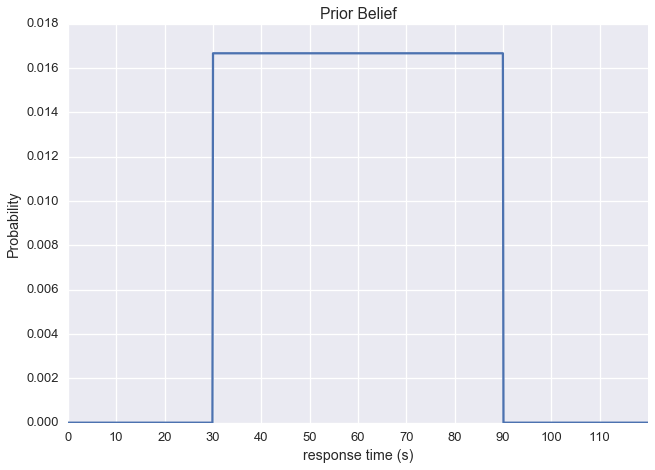

In [5]:
# <!-- collapse=True -->
x = np.linspace(0,120, 1000)
y = stats.uniform.pdf(x, loc=30, scale=60)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("response time (s)")
ax.set_ylabel("Probability")
ax.set_title("Prior Belief")
ax.set_xticks(np.arange(0,120,10));

Before we look at the 720 data points, $D$, we have a prior distrubution:

$$
p(\mu) = U(30,90) = 
\left\{
	\begin{array}{ll}
		1/60  & \mbox{if } 30 \leq x \leq 90 \\
		0 & \text{otherwise}
	\end{array}
\right.
$$

where $U$ is the uniform distrubution. We want to figure out what happens to this distrubution after observing the 720 response times. This distrubution is called the posterior and represented as a conditional probability: $P(\mu \ | \ D)$. We can get this probability by using Bayes Formula:

$$
\overbrace{p(\mu \ |\ D)}^{\text{posterior}} = \dfrac{\overbrace{p(D \ | \ \mu)}^{\text{likelihood}} \cdot \overbrace{p(\mu)}^{\text{prior}}}{\underbrace{p(D)}_{\text{marginal likelihood}}}
$$

We already have the prior and the likelihood, $p(D \ | \ \mu)$ is found in the previous section:

$$
p(D \ | \ \mu) = \prod_{i=1}^{720}p(x_i \ | \ \mu)
$$

The only thing left to find is the marginal liklehood, $p(D)$:

$$
p(D) = \int_{-\infty}^\infty p(D \ | \ \mu)\cdot p(\mu) du
$$

Pluggin in our expressions for $p(D \ | \ \mu)$ and $p(\mu)$:

$$
\begin{align*} 
p(D) &= \frac{1}{60}\int_{30}^{90}\prod_{i=1}^{720}\frac{e^{-\mu}\mu^{x_i}} {x_i!}du \\
&= \dfrac{1}{60}\int_{30}^{90}\prod_{i=1}^{720}\frac{e^{-\mu}\mu^{x_i}} {x_i!}du \\
&= \dfrac{1}{60}\prod_{i=1}^{720}\frac{1} {x_i!}\int_{30}^{90}e^{-\mu}\mu^{x_i}du
\end{align*}
$$
It turns out this integral does not have a closed form. If we plug in $\{x_1,..,x_{720}\}$, which are numbers, into this expression and integrate, $P(D)$ becomes just a number.

#### What can we do about the marginal likelihood?

There are basically two options:

- Nummerical integration
- Markov chain Monte Carlo

__Nummerical integration__: Recall that $D=\{x_1,..,x_{720}\}$ are just a list of 720 numbers, so the integral above can be solved nummerically. This is fine for this case, but it does not scale well. If our model needed more parameters besides the mean, the integral would not be 1-D anymore. As we add more parameters, the harder the integral is to do.

__Markov chain Monte Carlo__: A method to explore the parameter space without having to calculating the marginal likelihood. In this case, our parameter space is just the mean, $\mu$. This method will be described in the following section.

## Markov chain Monte Carlo In Nutshell

We believe that $\mu$ is a number between 30 and 90 seconds. For this method, we'll pick $\mu_{current}=40$ seconds to start off at. To get our next $\mu$ to test, we can grab a number from a normal distrubution with $\sigma=0.5$ centered around 0 and add it to $\mu$:

In [17]:
mu_current = 40
sigma_proposal = 0.5

np.random.seed(42)
delta_mu = stats.norm.rvs(loc=0, scale=sigma_proposal)
mu_proposal = mu_current + delta_mu
print("Proposed mu:", mu_proposal)

Proposed mu: 40.24835707650561


Next we have to see if this proposed $\mu$ is "good enough" to be our next mean.

#### How can we tell if the proposed mu is good enough?

Lets give the proposed $\mu$ a variable name: $\mu_{proposal}=40.2484$ seconds. Let's look at the ratio of the posteriors between $\mu_{proposal}$ and $\mu_{current}$:

$$
\begin{align*} 
r = \frac{p(\mu_{proposal} \ | \ D)}{p(\mu_{current} \ | \ D)} &= \frac{p(D \ | \ \mu_{proposal})p(\mu_{proposal})}{P(D)} \Biggm/ \frac{p(D \ | \ \mu_{current})p(\mu_{current})}{P(D)}\\
&= p(D \ | \ \mu_{proposal})p(\mu_{proposal}) \Bigm/ p(D \ | \ \mu_{current})p(\mu_{current})
\end{align*} 
$$

where r is called the acceptance ratio. Notice how the denominator cancels out and out the prior and likelihood survives in the ratio. The likelihood, $p(D \ | \ mu)$, turns out to be really small, so it is a good idea to take the log of this ratio:

$$
\begin{align*} 
\log(r)
&= \log(p(D \ | \ \mu_{proposal})p(\mu_{proposal}))-\log(p(D \ | \ \mu_{current})p(\mu_{current})) \\
&= \log(p(D \ | \ \mu_{proposal}))-\log(p(D \ | \ \mu_{current})) + \log(p(\mu_{proposal}))-\log(\mu_{current})) 
\end{align*}
$$

Let's define this log acceptance ratio function in python:

In [18]:
# log(p(mu))
def log_prior(mu):
    return stats.uniform.logpdf(mu, loc=30, scale=60)

def log_acceptance_ratio(mu_proposal, mu_current, response_times):
    return poisson_loglikelihood(mu_proposal, response_times)\
         - poisson_loglikelihood(mu_current, response_times)\
         + log_prior(mu_proposal) - log_prior(mu_current)

There are two possible outcomes for the log acceptance ratio:

- __r > 0__ : $\mu_{proposal}$ is more probable then $\mu_{current}$, so $\mu_{proposal}$ would become our next $\mu_{current}$.

- __r <= 0__ : $\mu_{proposal}$ is less probable then $\mu_{current}$, so we'll stay at $\mu_{current}$ 50% of the time.

#### Why stay at the current mean 50% of the time and not 100%?

It is possible that traveling to the proposal mean may guide us to a mean that is more probable than the current mean, after a few more iterations of this algorithm.

For our step, we will calculate the log acceptance ratio:

In [19]:
log_r = log_acceptance_ratio(mu_proposal, mu_current, response_times)
print("log(r) =", log_r)

log(r) = -16.5803313102


Since $\log(r) <= 0$, we will stay at $\mu_{current}$ 50% of the time and move to $\mu_{proposal}$ 50% of the time. Let's write this logic into a python function:

In [20]:
def move(log_r):
    # always move when r >0
    if log_r > 0:
        return True
    else:
        # pick number between 0 and 1
        # move if it's bigger than 0.5
        return stats.uniform.rvs() > 0.5

And use this function for our $\log(r)$:

In [21]:
move(log_r)

True

In this case, we will move to $\mu_{proposal}$, so our new $\mu_{current}$ will be 40.2484. After moving or staying, we will record the current mean. Then we'll repeat the whole process, by choosing another $\mu_{proposal}$. Since we are recording the new mean regardless of if we moved or not we may have a record that looks like this:

1. 40.0000
2. 40.2484
3. 40.2484
4. 40.2484
5. 40.3134

Notice how the 40.2484 is repeated 3 times between steps 2, 3, and 4. This means we have not moved from that spot three times.